<font size=5>신용카드 연체 예측 AI</font>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC



                                                      #y_true, y_pred
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score,  f1_score
from sklearn.metrics import precision_recall_curve    #y_true, probas_pred
from sklearn.metrics import roc_auc_score, roc_curve  #y_true, y_score

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# Data Load

In [3]:
train = pd.read_csv("./dataset/train.csv")

In [4]:
print(train.shape)
print(train.info())
train.head()

(26457, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   DAYS_BIRTH     26457 non-null  int64  
 3   car            26457 non-null  object 
 4   reality        26457 non-null  object 
 5   occyp_type     18286 non-null  object 
 6   family_size    26457 non-null  int64  
 7   child_num      26457 non-null  int64  
 8   income_total   26457 non-null  float64
 9   income_type    26457 non-null  object 
 10  edu_type       26457 non-null  object 
 11  family_type    26457 non-null  object 
 12  house_type     26457 non-null  object 
 13  DAYS_EMPLOYED  26457 non-null  int64  
 14  FLAG_MOBIL     26457 non-null  int64  
 15  work_phone     26457 non-null  int64  
 16  phone          26457 non-null  int64  
 17  email          26457 non-null  int64  

,index,gender,DAYS_BIRTH,car,reality,occyp_type,family_size,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,begin_month,credit
0,0,F,-13899,N,N,NaN,2,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-4709,1,0,0,0,-6,1
1,1,F,-11380,N,Y,Laborers,3,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-1540,1,0,0,1,-5,1
2,2,M,-19087,Y,Y,Managers,2,0,450000.0,Working,Higher education,Married,House / apartment,-4434,1,0,1,0,-22,2
3,3,F,-15088,N,Y,Sales staff,2,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-2092,1,0,1,0,-37,0
4,4,F,-15037,Y,Y,Managers,2,0,157500.0,State servant,Higher education,Married,House / apartment,-2105,1,0,0,0,-26,2


# EDA

## Survived : Traget Feature

In [5]:
train["credit"].value_counts() 
# (train["credit"].value_counts() / train.shape[0]) * 100
# ((train["credit"].value_counts() / train.shape[0]) * 100).plot(kind='bar')

2    16968
1     6267
0     3222
Name: credit, dtype: int64

## 유니크피쳐

In [6]:
def my_dfcheck(prm='null'):  #파라미터 : 'null' 또는 'unique'
    if prm == 'unique':
        s = train.nunique()
    else:
        s = train.isna().sum()
    rate = np.round( (s.values  / len(train)) *100,  1)
    dic = {"컬럼":s.index , "카운트":s.values, "비율":rate}
    df = pd.DataFrame(dic).sort_values('카운트', ascending=False)
    return df.T

In [7]:
my_dfcheck ('unique') 

,0,2,13,8,18,5,6,7,12,11,10,9,19,1,4,15,16,17,3,14
컬럼,index,DAYS_BIRTH,DAYS_EMPLOYED,income_total,begin_month,occyp_type,family_size,child_num,house_type,family_type,edu_type,income_type,credit,gender,reality,work_phone,phone,email,car,FLAG_MOBIL
카운트,26457,6621,3470,249,61,18,10,9,6,5,5,5,3,2,2,2,2,2,2,1
비율,100.0,25.0,13.1,0.9,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 불필요한 피쳐 삭제
* FLAG_MOBIL 카운트 수는 1이다  == 단일값 삭제
* index 피쳐

In [8]:
train = train.drop(['FLAG_MOBIL','index'], axis=1)

In [9]:
train.head(1)

,gender,DAYS_BIRTH,car,reality,occyp_type,family_size,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,begin_month,credit
0,F,-13899,N,N,NaN,2,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-4709,0,0,0,-6,1


## 결측 확인
* 16  occyp_type     18286 non-null  object 

## Object 타입
* binary : ['gender', 'car', 'reality'] 
* multi  : ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

In [10]:
obj_col_list = train.select_dtypes(include='object').columns.tolist()
print(obj_col_list)
train[obj_col_list].head()

['gender', 'car', 'reality', 'occyp_type', 'income_type', 'edu_type', 'family_type', 'house_type']


,gender,car,reality,occyp_type,income_type,edu_type,family_type,house_type
0,F,N,N,NaN,Commercial associate,Higher education,Married,Municipal apartment
1,F,N,Y,Laborers,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment
2,M,Y,Y,Managers,Working,Higher education,Married,House / apartment
3,F,N,Y,Sales staff,Commercial associate,Secondary / secondary special,Married,House / apartment
4,F,Y,Y,Managers,State servant,Higher education,Married,House / apartment


## Numeric 타입
* unique : ['index'] 
* target : ['credit'] 
* 범주형  : ['FLAG_MOBIL', 'work_phone', 'phone', 'email']
* 연속형  : ['income_total'] ['DAYS_BIRTH', 'DAYS_EMPLOYED','begin_month'] ['child_num','family_size']

In [11]:
obj_col_list = train.select_dtypes(exclude='object').columns.tolist()
print(obj_col_list)
train[obj_col_list].head()

['DAYS_BIRTH', 'family_size', 'child_num', 'income_total', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'begin_month', 'credit']


,DAYS_BIRTH,family_size,child_num,income_total,DAYS_EMPLOYED,work_phone,phone,email,begin_month,credit
0,-13899,2,0,202500.0,-4709,0,0,0,-6,1
1,-11380,3,1,247500.0,-1540,0,0,1,-5,1
2,-19087,2,0,450000.0,-4434,0,1,0,-22,2
3,-15088,2,0,202500.0,-2092,0,1,0,-37,0
4,-15037,2,0,157500.0,-2105,0,0,0,-26,2


## 아웃라이어 (Outlier) : 이상치
* child_num   :  14(3), 19(1)
* family_size :  15(3), 20(1)

<pre>
train = train.drop( ['c1', 'c2'] , axis=1)
train = train.drop( [idx1, idx2] , axis=0)

In [12]:
train[obj_col_list].describe()

,DAYS_BIRTH,family_size,child_num,income_total,DAYS_EMPLOYED,work_phone,phone,email,begin_month,credit
count,26457.000000,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,-15958.053899,2.196848,0.428658,1.873065e+05,59068.750728,0.224742,0.294251,0.091280,-26.123294,1.519560
std,4201.589022,0.916717,0.747326,1.018784e+05,137475.427503,0.417420,0.455714,0.288013,16.559550,0.702283
min,-25152.000000,1.000000,0.000000,2.700000e+04,-15713.000000,0.000000,0.000000,0.000000,-60.000000,0.000000
25%,-19431.000000,2.000000,0.000000,1.215000e+05,-3153.000000,0.000000,0.000000,0.000000,-39.000000,1.000000
50%,-15547.000000,2.000000,0.000000,1.575000e+05,-1539.000000,0.000000,0.000000,0.000000,-24.000000,2.000000
75%,-12446.000000,3.000000,1.000000,2.250000e+05,-407.000000,0.000000,1.000000,0.000000,-12.000000,2.000000
max,-7705.000000,20.000000,19.000000,1.575000e+06,365243.000000,1.000000,1.000000,1.000000,0.000000,2.000000


In [13]:
train[train['child_num']>=14][['child_num','family_size']]

,child_num,family_size
8462,14,15
9021,14,15
10731,19,20
25390,14,15


In [14]:
train.shape

(26457, 18)

In [15]:
# train = train.drop( [8462, 9021, 10731, 25390] , axis=0)
drop_idx = train[train['child_num']>=14][['child_num','family_size']].index
print(drop_idx)
train = train.drop( drop_idx , axis=0)

Int64Index([8462, 9021, 10731, 25390], dtype='int64')


In [16]:
train.shape

(26453, 18)

# 가공

## 결측처리 
* occyp_type이 NaN이다  == 일하는중_YN(0) == DAYS_EMPLOYED가 양수다

In [17]:
train['occyp_type'].isna().sum()

8171

* 신규 컬럼 : 일하는중_YN
DAYS_EMPLOYED 양수이면 휴직중이다.

<pre>
현재 재직중이다 == 일하는중_YN = Y(1)
현재 집에있다   == 일하는중_YN = N(0)

In [18]:
train['일하는중_YN'] = train['DAYS_EMPLOYED'].apply(lambda x : 0 if x > 0 else 1)

In [19]:
train['일하는중_YN'].value_counts()

1    22015
0     4438
Name: 일하는중_YN, dtype: int64

In [20]:
pd.crosstab(train['occyp_type'], train['일하는중_YN'] ).head()

일하는중_YN,1
occyp_type,
Accountants,902
Cleaning staff,403
Cooking staff,457
Core staff,2646
Drivers,1572


* 일을하고 있는데도 occyp_type이 널인경우 == 최빈도

In [21]:
idx = train[(train['일하는중_YN']==1) & (train['occyp_type'].isna()==True) ]['occyp_type'].index
idx

Int64Index([    0,     8,    19,    20,    23,    27,    49,    54,    72,
               76,
            ...
            26419, 26420, 26424, 26426, 26430, 26433, 26435, 26437, 26449,
            26453],
           dtype='int64', length=3733)

In [22]:
train.loc[idx, 'occyp_type'] = 'Laborers'

* 정말로 일을 안하고 있어서  occyp_type이 널인경우 == 백수('')

In [23]:
train[train['일하는중_YN']==0]['occyp_type'][:5]

14    NaN
18    NaN
21    NaN
24    NaN
46    NaN
Name: occyp_type, dtype: object

In [24]:
train['occyp_type'].fillna('', inplace=True)

In [25]:
train['occyp_type'].isna().sum()

0

## 카테고리화 
* 8개 피쳐 == 인코딩 (글자 --> 숫자)
<pre>
object   binary  : ['gender', 'car', 'reality']
object   multi   : ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

* get_dummies() 대상 선정 : 점수 봐가면서 결정

In [26]:
# multi_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
# for col in multi_cols:
#     print(col, train[col].nunique())

* 글자 --> 숫자
<pre>
dict = {"F":1, "M":0}
train["gender"] = train["gender"].map(dict)

In [27]:
col_list = ['gender', 'car', 'reality'] + ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
print(col_list)

for col in col_list:
    arr = train[col].unique()
    dict = {}
    for i, key in enumerate(arr):  #['F' 'M']
        dict[key] = i
    #print(dict)
    train[col] = train[col].map(dict)

['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']


In [28]:
train.head(1)

,gender,DAYS_BIRTH,car,reality,occyp_type,family_size,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,begin_month,credit,일하는중_YN
0,0,-13899,0,0,0,2,0,202500.0,0,0,0,0,-4709,0,0,0,-6,1,1


# 우선 점수부터 보자(1차 점수)
* 결측   XX
* object XX

In [29]:
def my_score(y_test, pred):
    report = classification_report(y_test, pred)
    print(report)
    # [None, 'micro', 'macro', 'weighted'].
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred,       average='macro')
    f1 = f1_score(y_test, pred,               average='macro')
    print(f"정확도{accuracy:.4f}  정밀도{precision:.4f}  재현률{recall:.4f}  f1{f1:.4f}")

In [30]:
def my_fit_score(train, target="credit"):
    model_list = [RandomForestClassifier(n_estimators=100, random_state=1234) ,
                  LogisticRegression(penalty="l2", random_state=1234),
              #KNeighborsClassifier(),
              #DecisionTreeClassifier(),
              #LinearSVC()
             ]
    
    y = train[target]
    X = train.drop([target], axis=1)

    X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                    random_state=1234,
                                                    shuffle=True
                                                      )
    for model in model_list:
        model.fit(X_train, y_train)  #---학습해라
        pred = model.predict(X_test)
        #acc_score = accuracy_score(y_test, pred)
        print(f"{model.__class__.__name__}")
        
        my_score(y_test, pred)
        
        #---------------- 피쳐 중요도 (tree 모델에서만 사용 가능) -------------
        # plt.figure(figsize=(12,3))
        # plt.xticks(rotation=90)
        # plt.bar(X.columns, model.feature_importances_)
        

In [31]:
my_fit_score(train)

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.45      0.30      0.36       618
           1       0.59      0.45      0.51      1287
           2       0.75      0.87      0.81      3386

    accuracy                           0.70      5291
   macro avg       0.60      0.54      0.56      5291
weighted avg       0.68      0.70      0.68      5291

정확도0.6993  정밀도0.5991  재현률0.5378  f10.5583
LogisticRegression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       618
           1       0.00      0.00      0.00      1287
           2       0.64      1.00      0.78      3386

    accuracy                           0.64      5291
   macro avg       0.21      0.33      0.26      5291
weighted avg       0.41      0.64      0.50      5291

정확도0.6400  정밀도0.2133  재현률0.3333  f10.2602


Index(['child_num', 'family_size', 'DAYS_BIRTH', '일하는중_YN', 'car'], dtype='object')


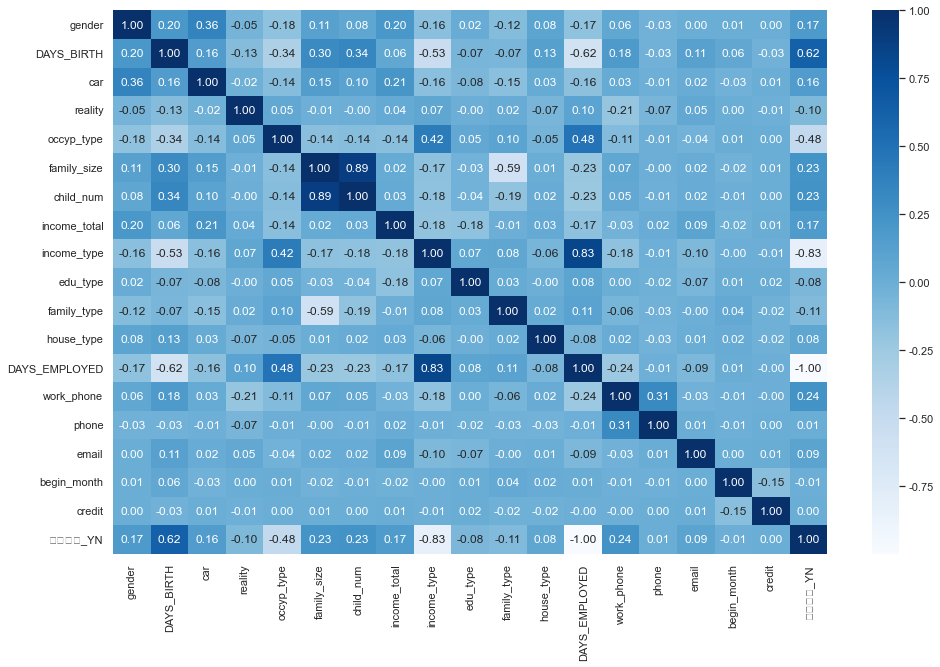

In [32]:
plt.figure(figsize=(16,10))  #nlargest, nsmallest 
sns.heatmap(train.corr(), cmap='Blues' , annot=True, fmt=".2f")
print(train.corr().nlargest(5, 'child_num').index)

# 본격적 가공

<pre>
* 피쳐중요도(1회 학습 후 진행) -- 가공
-----------------------------------------------
* 전진선택 후진소거 -- 피쳐상관도 -- 

* 수입 --- log스케일링, 구간화
* FLAG_MOBIL  : 단일값

* 무직 - 고용일수-년 331557 -- 0
* ------------- CAR + REALITY = 재산 1 1 = 2
* income_total < 1y : 고용일수 -- 일계산  yy..mm..w.. q,s
* 직업 DEGREE - CAR 결측처리 ???


* 수입 / 나 .. 가족구성원   생활비--소득격차 ****
* uniq.ID ***
* 태어나날  + 고용일수  -- day..weight  rate
* 고용일수/ 수입 - ..rate


## 자율적 분석

In [33]:
train[train['DAYS_EMPLOYED']>0][['DAYS_BIRTH','DAYS_EMPLOYED', 'income_total']].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,income_total
count,4438.000000,4438.0,4438.000000
mean,-21769.383281,365243.0,149593.424966
std,1905.690033,0.0,77498.170281
min,-25152.000000,365243.0,29250.000000
25%,-23054.500000,365243.0,94500.000000
50%,-21943.500000,365243.0,135000.000000
75%,-20858.250000,365243.0,180000.000000
max,-8145.000000,365243.0,742500.000000


In [34]:
pd.crosstab(train['family_size'],train['child_num'])


child_num,0,1,2,3,4,5,7
family_size,,,,,,,
1,5103,5,1,0,0,0,0
2,13237,869,0,0,0,0,0
3,0,4512,120,0,0,0,0
4,0,0,2241,19,0,0,0
5,0,0,0,287,4,0,0
6,0,0,0,0,43,1,0
7,0,0,0,0,0,9,0
9,0,0,0,0,0,0,2


In [35]:
train.loc[ (train['family_size']==1) & (train['child_num']==0) ,'credit'].value_counts()/train.shape[0]



# train.loc[train['child_num']>0 ,'credit'].value_counts()/train.shape[0]
# 허강호(중복)님이 모두에게 06:09 PM
# train[['child_num','family_size','credit']][(train['family_size']-train['child_num'])==2].value_counts()
# train[['child_num','family_size','credit']][(train['family_size']-train['child_num'])==1].value_counts()


2    0.120213
1    0.049824
0    0.022871
Name: credit, dtype: float64

In [36]:
train.loc[ (train['family_size']==2) & (train['child_num']==0) ,'credit'].value_counts()/train.shape[0]

2    0.325294
1    0.113560
0    0.061543
Name: credit, dtype: float64

In [37]:
pd.crosstab(train.loc[(train['family_size']-train['child_num']==1) &(train['family_size']!=1) ,'credit'],  
            train.loc[train['family_size']-train['child_num']==1 ,'child_num'])



child_num,1,2,3,4,5
credit,,,,,
0,92,20,3,1,0
1,245,20,5,0,0
2,532,80,11,3,1


In [38]:
train[['child_num','family_size','credit']][(train['family_size']-train['child_num'])==2].value_counts()


child_num  family_size  credit
0          2            2         8605
                        1         3004
1          3            2         2854
0          2            0         1628
2          4            2         1478
1          3            1         1068
                        0          590
2          4            1          515
                        0          248
3          5            2          187
                        1           74
                        0           26
4          6            2           24
                        1           12
                        0            7
5          7            1            6
                        0            2
7          9            2            2
5          7            2            1
dtype: int64

In [39]:
train[['child_num','family_size','credit']][(train['family_size']-train['child_num'])==1].value_counts()


child_num  family_size  credit
0          1            2         3180
                        1         1318
                        0          605
1          2            2          532
                        1          245
                        0           92
2          3            2           80
                        0           20
                        1           20
3          4            2           11
                        1            5
                        0            3
4          5            2            3
                        0            1
5          6            2            1
dtype: int64

## 날짜 관련 가공 
* ['DAYS_BIRTH', 'DAYS_EMPLOYED','begin_month']

* DAYS_EMPLOYED: 업무 시작일 --> 양수 값은 고용되지 않은 상태를 의미함
* train['HIRE_YN']  = 0

In [40]:
# train['HIRE_YN'] = 1
# train.loc[ train['DAYS_EMPLOYED']>0 , 'HIRE_YN' ] = 0

In [41]:
train['HIRE_YN']  = train['DAYS_EMPLOYED'].apply(lambda x: 0 if x>0 else 1)

In [42]:
train['HIRE_YN'].value_counts()

1    22015
0     4438
Name: HIRE_YN, dtype: int64

In [43]:
train[['DAYS_BIRTH', 'DAYS_EMPLOYED','begin_month']].head(3)

,DAYS_BIRTH,DAYS_EMPLOYED,begin_month
0,-13899,-4709,-6
1,-11380,-1540,-5
2,-19087,-4434,-22


In [44]:
train['Y_DAYS_BIRTH'] =  ((train['DAYS_BIRTH']*-1)/(30*12)).astype('int')
train['M_DAYS_BIRTH'] =  ((train['DAYS_BIRTH']*-1)/(30)).astype('int')
train['W_DAYS_BIRTH'] =  ((train['DAYS_BIRTH']*-1)/(7)).astype('int')

train['Y_DAYS_EMPLOYED'] =  ((train['DAYS_EMPLOYED']*-1)/(30*12)).astype('int')
train['M_DAYS_EMPLOYED'] =  ((train['DAYS_EMPLOYED']*-1)/(30)).astype('int')
train['W_DAYS_EMPLOYED'] =  ((train['DAYS_EMPLOYED']*-1)/(7)).astype('int')

train['Y_begin_month'] =  ((train['begin_month']*-1)/(12)).astype('int')
train['M_begin_month'] =  train['begin_month']*-1
train['W_begin_month'] =  ((train['begin_month']*-30)/(7)).astype('int')


In [45]:
train.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED','begin_month'], axis=1, inplace=True)

In [46]:
train.head()

,gender,car,reality,occyp_type,family_size,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,credit,일하는중_YN,HIRE_YN,Y_DAYS_BIRTH,M_DAYS_BIRTH,W_DAYS_BIRTH,Y_DAYS_EMPLOYED,M_DAYS_EMPLOYED,W_DAYS_EMPLOYED,Y_begin_month,M_begin_month,W_begin_month
0,0,0,0,0,2,0,202500.0,0,0,0,0,0,0,0,1,1,1,38,463,1985,13,156,672,0,6,25
1,0,0,1,0,3,1,247500.0,0,1,1,1,0,0,1,1,1,1,31,379,1625,4,51,220,0,5,21
2,1,1,1,1,2,0,450000.0,1,0,0,1,0,1,0,2,1,1,53,636,2726,12,147,633,1,22,94
3,0,0,1,2,2,0,202500.0,0,1,0,1,0,1,0,0,1,1,41,502,2155,5,69,298,3,37,158
4,0,1,1,1,2,0,157500.0,2,0,0,1,0,0,0,2,1,1,41,501,2148,5,70,300,2,26,111


In [47]:
my_fit_score(train)

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.46      0.23      0.31       618
           1       0.60      0.39      0.48      1287
           2       0.74      0.90      0.81      3386

    accuracy                           0.70      5291
   macro avg       0.60      0.51      0.53      5291
weighted avg       0.67      0.70      0.67      5291

정확도0.6991  정밀도0.5999  재현률0.5080  f10.5310
LogisticRegression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       618
           1       0.00      0.00      0.00      1287
           2       0.64      1.00      0.78      3386

    accuracy                           0.64      5291
   macro avg       0.21      0.33      0.26      5291
weighted avg       0.41      0.64      0.50      5291

정확도0.6400  정밀도0.2133  재현률0.3333  f10.2602


* 아래처럼 계산하면 편하지만 로컬에서 구동 불가

In [48]:
# import datetime as dt
# from dateutil.rrule import rrule, YEARLY, MONTHLY, WEEKLY

# def my_convert_ymw(day) :
#     now = dt.datetime.now()
#     old = now - dt.timedelta(days=day)
#     y= len([y for y in rrule(freq=YEARLY ,dtstart=old , until=now)])  -1
#     m = len([y for y in rrule(freq=MONTHLY ,dtstart=old , until=now)]) -1
#     w = len([y for y in rrule(freq=WEEKLY  ,dtstart=old , until=now)]) -1
#     return y,m,w

# train2 = train.iloc[:50].copy()
# #my_convert_ymw(13899) 
# train2[['DAY_BIRTH_Y','DAY_BIRTH_M','DAY_BIRTH_W']] = train2.apply(lambda x : my_convert_ymw(x['DAYS_BIRTH']*-1), 
#                                        axis=1, result_type="expand")
# train2.head()

## income_total
* 방법1\) 지나치게 큰 수치형은 log 변환해서 작은 값으로 변경

In [49]:
# res0= np.log(10000)  
# res1= np.log(10000)  + 1
# res2= np.log1p(10000) 
# print(res0, res1, res2)

In [50]:
# train['income_total'] = train['income_total'].apply(lambda x : np.log1p(x))
train['income_total'] = np.log1p(train['income_total'])
train.head()

,gender,car,reality,occyp_type,family_size,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,credit,일하는중_YN,HIRE_YN,Y_DAYS_BIRTH,M_DAYS_BIRTH,W_DAYS_BIRTH,Y_DAYS_EMPLOYED,M_DAYS_EMPLOYED,W_DAYS_EMPLOYED,Y_begin_month,M_begin_month,W_begin_month
0,0,0,0,0,2,0,12.218500,0,0,0,0,0,0,0,1,1,1,38,463,1985,13,156,672,0,6,25
1,0,0,1,0,3,1,12.419170,0,1,1,1,0,0,1,1,1,1,31,379,1625,4,51,220,0,5,21
2,1,1,1,1,2,0,13.017005,1,0,0,1,0,1,0,2,1,1,53,636,2726,12,147,633,1,22,94
3,0,0,1,2,2,0,12.218500,0,1,0,1,0,1,0,0,1,1,41,502,2155,5,69,298,3,37,158
4,0,1,1,1,2,0,11.967187,2,0,0,1,0,0,0,2,1,1,41,501,2148,5,70,300,2,26,111


In [51]:
my_fit_score(train)

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.46      0.23      0.30       618
           1       0.60      0.39      0.48      1287
           2       0.74      0.90      0.81      3386

    accuracy                           0.70      5291
   macro avg       0.60      0.51      0.53      5291
weighted avg       0.67      0.70      0.67      5291

정확도0.6991  정밀도0.5990  재현률0.5074  f10.5302
LogisticRegression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       618
           1       0.00      0.00      0.00      1287
           2       0.64      1.00      0.78      3386

    accuracy                           0.64      5291
   macro avg       0.21      0.33      0.26      5291
weighted avg       0.41      0.64      0.50      5291

정확도0.6400  정밀도0.2133  재현률0.3333  f10.2602


* 방법2) Scaler를 이용해 값을 수의 범위 조절
<pre>
StandardScaler : 평균0 ~ 편차1  : 정규분포 -->          !!!!반드시 선행 아웃라이어 처리 후 시행
RobustScaler   : 4분위          : 아웃라이어에 강하다
MinMaxScaler   : 최소0 ~ 최대1  : train 에 포함되지 않는 test 데이터가 있을 경우 주의~!!!!!

<pre>

# 원본
정확도0.6887  정밀도0.5956  재현률0.5052  f10.5248
정확도0.6279  정밀도0.2093  재현률0.3333  f10.2571

# log변환
#정확도0.6965  정밀도0.5902  재현률0.5035  f10.5250
#정확도0.6449  정밀도0.2150  재현률0.3333  f10.2614

#-------------log + StandardScaler 
# RandomForestClassifier
# 정확도0.6978  정밀도0.5919  재현률0.5095  f10.5306
# LogisticRegression
# 정확도0.6369  정밀도0.2123  재현률0.3333  f10.2594

#-------------log + RobustScaler 
# RandomForestClassifier
#  정확도0.6912  정밀도0.5723  재현률0.4908  f10.5089
# LogisticRegression
# 정확도0.6490  정밀도0.2163  재현률0.3333  f10.2624

#-------------log + MinMaxScaler 
# RandomForestClassifier
# 정확도0.6951  정밀도0.5912  재현률0.5036  f10.5225
# LogisticRegression
# 정확도0.6420  정밀도0.2140  재현률0.3333  f10.2607

In [52]:
ss_scaler = StandardScaler()
rs_scaler = RobustScaler() 
mm_scaler = MinMaxScaler()

#scaler_list = [ss_scaler,rs_scaler,mm_scaler ]
scaler_list = [ss_scaler]
for scaler in scaler_list:
    #scaler.fit(X_train)  #-----------------완전 주의주의주의
    #X_train_sacler = scaler.transform(X_train)
    #X_test_scaler = scaler.transform(X_test)
    
    scaler.fit(train[['income_total']])
    arr = scaler.transform(train[['income_total']])
    #print(arr)
    my_fit_score(train)

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.46      0.23      0.30       618
           1       0.60      0.39      0.48      1287
           2       0.74      0.90      0.81      3386

    accuracy                           0.70      5291
   macro avg       0.60      0.51      0.53      5291
weighted avg       0.67      0.70      0.67      5291

정확도0.6991  정밀도0.5990  재현률0.5074  f10.5302
LogisticRegression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       618
           1       0.00      0.00      0.00      1287
           2       0.64      1.00      0.78      3386

    accuracy                           0.64      5291
   macro avg       0.21      0.33      0.26      5291
weighted avg       0.41      0.64      0.50      5291

정확도0.6400  정밀도0.2133  재현률0.3333  f10.2602


### CAR + 2*REALITY = 재산 1 1 = 2

In [53]:
train['CAR_REALITY'] = train['car'] + train['reality']
train.drop(['car','reality'], axis=1, inplace=True)
my_fit_score(train)

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.46      0.22      0.29       618
           1       0.61      0.39      0.48      1287
           2       0.74      0.91      0.81      3386

    accuracy                           0.70      5291
   macro avg       0.60      0.51      0.53      5291
weighted avg       0.67      0.70      0.67      5291

정확도0.7016  정밀도0.6019  재현률0.5058  f10.5286
LogisticRegression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       618
           1       0.00      0.00      0.00      1287
           2       0.64      1.00      0.78      3386

    accuracy                           0.64      5291
   macro avg       0.21      0.33      0.26      5291
weighted avg       0.41      0.64      0.50      5291

정확도0.6400  정밀도0.2133  재현률0.3333  f10.2602


In [54]:
train.head()

,gender,occyp_type,family_size,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,credit,일하는중_YN,HIRE_YN,Y_DAYS_BIRTH,M_DAYS_BIRTH,W_DAYS_BIRTH,Y_DAYS_EMPLOYED,M_DAYS_EMPLOYED,W_DAYS_EMPLOYED,Y_begin_month,M_begin_month,W_begin_month,CAR_REALITY
0,0,0,2,0,12.218500,0,0,0,0,0,0,0,1,1,1,38,463,1985,13,156,672,0,6,25,0
1,0,0,3,1,12.419170,0,1,1,1,0,0,1,1,1,1,31,379,1625,4,51,220,0,5,21,1
2,1,1,2,0,13.017005,1,0,0,1,0,1,0,2,1,1,53,636,2726,12,147,633,1,22,94,2
3,0,2,2,0,12.218500,0,1,0,1,0,1,0,0,1,1,41,502,2155,5,69,298,3,37,158,1
4,0,1,2,0,11.967187,2,0,0,1,0,0,0,2,1,1,41,501,2148,5,70,300,2,26,111,2


### 범주화
<pre>
numeric 연속형 - log    : ['income_total'] 
numeric 연속형 - date   : ['DAYS_BIRTH', 'DAYS_EMPLOYED','begin_month'] 
numeric 연속형 - bining : ['child_num','family_size']


# 모델 학습 & 평가
* 모델이 예측력이 좋다
  - 양질의 데이터 ( 정규분포를 따른다)
  - 강력한 모델
   
* 모델이 예측력이 떨어진다.
  - 불량 데이터 (데이터 분산(편차) 고르지 못하다, 패턴을 잡을 수 없는 데이터)
  - 모델이 약하다
  - 예측모델이 지나치게 단순(언디피팅)/복잡(오버피팅)
  - 데이터 학습량이 적다 (P학습이 적은경우:th낮춘다, <font color=red> 데이터증강(학습량N배화) </font>)
  


# 검증 & 튜닝

## 임계치 조정해 양성학습 증가

## 학습 데이터 증강
<pre>
<font color='red'><b>
 KFold()           : 순서데로 5등분, 
 StratifiedKFold() : y를 골로루 섞어서 5등분
 cross_val_score() : 단순히 [점수1, 점수2...만 리턴
 GridSearchCV()    : cv=5 + 모델튜닝 --> fit() predit() score() 

<pre>
Classification

‘accuracy’   metrics.accuracy_score()

‘f1’          metrics.f1_score(  average='binary')       # target 0, 1
‘f1_micro’    metrics.f1_score(  average='micro')        # target 0, 1, 2 ....
‘f1_macro’    metrics.f1_score(  average='macro')        # target 0, 1, 2 ....

‘precision’     metrics.precision_score(average='binary')
‘precision_...’ metrics.precision_score(average='micro')

‘recall’        metrics.recall_score(average='binary')
‘recall_...’    metrics.recall_score(average='micro')

‘roc_auc’     metrics.roc_auc_score(multi_class="raise")  # target 0, 1
‘roc_auc_ovr’ metrics.roc_auc_score(multi_class="ovr")    # target 0, 1, 2 ....
‘roc_auc_ovo’ metrics.roc_auc_score(multi_class="ovo")    # target 0, 1, 2 ....

**‘neg_log_loss’  metrics.log_loss()  #predict_proba 

### cross_val_score()
* cv : Flod()
  - 분류(StratifiedKFold()) : 한칸(Fold)마다 target 비율에 맞게 골고루 섞어 넣어라
  - 회귀(KFold())           : 회귀, 시계열

In [55]:
y = train['credit']
X = train.drop(['credit'], axis=1)

### KFold()

In [57]:
model = RandomForestClassifier(n_estimators=100, random_state=1234)
kfold = KFold(n_splits=5) #, shuffle=False, random_state=1234)
f1_list = []
for train_index, test_index  in kfold.split(X, y) :  #train_index, test_index
    #X_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.2)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1 = f1_score(y_test, pred, average="macro")
    f1_list.append(f1)
    
print( f"f1 평균 점수 : {np.array(f1_list).mean():.4f} ")

f1 평균 점수 : 0.5263 


### StratifiedKFold()

In [58]:
model = RandomForestClassifier(n_estimators=100, random_state=1234)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234) #----------아까는 KFold()
f1_list = []
for i, (train_index, test_index)  in enumerate(skfold.split(X, y)) :  #train_index, test_index
    #X_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.2)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1 = f1_score(y_test, pred, average="macro")
    print(f"{i}Fold : {f1}")
    f1_list.append(f1)
print( f"f1 평균 점수 : {np.array(f1_list).mean():.4f} ")

0Fold : 0.5311108239602925
1Fold : 0.5364710959865857
2Fold : 0.5131353374902332
3Fold : 0.5378241423283799
4Fold : 0.519778453567188
f1 평균 점수 : 0.5277 


### cross_val_score()

In [59]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234) 
arr_score = cross_val_score(model, X,y, scoring='f1_macro',cv=skfold)  #cv=5 shuffle=True, random_state=1234)
print(arr_score)
print(f"cv5 평균점수 {arr_score.mean():.4f}")   # 원본 f1 0.5278

[0.53111082 0.5364711  0.51313534 0.53782414 0.51977845]
cv5 평균점수 0.5277


### GridSearchCV()
<pre>
RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [61]:
y = train['credit']
X = train.drop(['credit'], axis=1)
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   random_state=1234,
                                                   shuffle=True
                                                      )

model = RandomForestClassifier(n_estimators=100, random_state=1234)
#-- 튜닝 : 하이퍼파라미터 값을 임의로 변경해서 모델의 성능을 좋게 한다.
myparam = {'n_estimators':[100,200],
           'min_samples_split' : [1,2,3,4]
        }

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234) 
gcv_model = GridSearchCV(model, param_grid=myparam, scoring="f1_macro", refit=True, cv=skfold)


gcv_model.fit(X_train, y_train)
print(gcv_model.best_score_)
print(gcv_model.best_params_)
# print(gcv_model.cv_results_)



0.5234351726986272
{'min_samples_split': 2, 'n_estimators': 100}


In [64]:
pred = gcv_model.predict(X_test)
f1 = f1_score(y_test, pred, average='macro')
print(f"GCV f1 점수 {f1:.4f}")   # 원본 f1 0.5278    S.Kfold: 0.5277

GCV f1 점수 0.5286
